<a href="https://colab.research.google.com/github/kartik727/neural-machine-translation/blob/master/Seq2Seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq with attention

## Dependencies
Primary library used for modelling and training - trax

## Data - Tensorflow Datasets (TFDS)
1. OPUS (`'opus'`)

In [41]:
import random
import numpy as np
import re
from collections import defaultdict
import os
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import shutil

import nltk
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Utils

!git clone https://gist.github.com/c47d0ad11b63acd334e760fc4ed21488.git namespace
!git clone https://gist.github.com/553d2d565a17788d6217eba65e770c41.git tb_logger

Cloning into 'namespace'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
Cloning into 'tb_logger'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.


In [3]:
from namespace.namespace import Namespace
from tb_logger.tensorboard_logger_2 import Logger as TB_Logger

In [4]:
config_dict = {
    'model' : {
        'embedding_size' : 256,
        'n_encoder_layers' : 1,
        'n_decoder_layers' : 1,
        'n_attention_heads' : 1,
        'attention_dropout' : 0.,
        'n_units' : 1024,
        'batch_size' : 32,
    },
    'languages' : {
        'input' : {
            'name' : 'en',
            'sentence_maxlen' : 30,
            'vocab_size' : 20_000,
        },
        'target' : {
            'name' : 'de',
            'sentence_maxlen' : 30,
            'vocab_size' : 20_000,
        }
    },
    'data' : {
        'dataset_name' : 'opus',
        'load_pcnt' : 5,
        'shuffle' : True
    },
    'preprocessing' : {
        'start_token' : '<start>',
        'end_token' : '<end>',
        'oov_token' : '<unk>',
        'padding' : 'post'
    },
    'training' : {
        'epochs' : 10
    },
    'logging' : {
        'dir' : '/content/out/tensorboard/logs/'
        'name' : 'seq2seq machine translation'
        'description' : 'NMT using seq2seq model with attention'
    }
}

config = Namespace(**config_dict)

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print('Not connected to a TPU runtime')

Not connected to a TPU runtime


In [7]:
logger = TB_Logger(config.logging.dir)

In [8]:
dataset_train = tfds.load(config.data.dataset_name, split=f'train[:{config.data.load_pcnt}%]', batch_size=-1, shuffle_files=config.data.shuffle)
ds_np = tfds.as_numpy(dataset_train)

Shuffling and writing examples to /root/tensorflow_datasets/opus/medical/0.1.0.incompleteJBFWR7/opus-train.tfrecord


Dataset opus downloaded and prepared to /root/tensorflow_datasets/opus/medical/0.1.0. Subsequent calls will reuse this data.


In [9]:
def preprocess_sentence(w, max_len):
    w = w.decode().lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    w = ' '.join(w.split()[:max_len])

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = f'{config.preprocessing.start_token} {w} {config.preprocessing.end_token}'
    return w

In [10]:
def preprocess_data(data, max_len):
    res = []
    for sentence in data:
        res.append(preprocess_sentence(sentence, max_len))
    return np.array(res)

In [11]:
lang_tokenizer = {}
preprocessed_dataset = {}

for lang in config.languages:
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=lang.vocab_size,
        filters='',
        oov_token=config.preprocessing.oov_token
        )
    preprocessed_data = preprocess_data(ds_np[lang.name], lang.sentence_maxlen)
    tokenizer.fit_on_texts(preprocessed_data)
    lang_tokenizer[lang.name] = tokenizer

    tensor = tokenizer.texts_to_sequences(preprocessed_data)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=config.preprocessing.padding)
    preprocessed_dataset[lang.name] = tensor

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((
    preprocessed_dataset[config.languages.input.name],
    preprocessed_dataset[config.languages.target.name]
    ))
dataset = dataset.batch(config.model.batch_size, drop_remainder=True)

In [13]:
steps_per_epoch = len(dataset)

vocab_input_size = len(lang_tokenizer[config.languages.input.name].word_index)+1
vocab_target_size = len(lang_tokenizer[config.languages.target.name].word_index)+1

In [14]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 32]), TensorShape([32, 32]))

In [15]:
max_len_inp = preprocessed_dataset[config.languages.input.name].shape[1]
max_len_targ = preprocessed_dataset[config.languages.target.name].shape[1]

## Keras

Source: [Tensorflow NMT tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

In [16]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_input_size, config.model.embedding_size, config.model.n_units, config.model.batch_size)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (32, 32, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 32, 1)


In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_target_size, config.model.embedding_size, config.model.n_units, config.model.batch_size)

sample_decoder_output, _, _ = decoder(tf.random.uniform((config.model.batch_size, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (32, 25371)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = '/content/out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([lang_tokenizer[config.languages.target.name].word_index[config.preprocessing.start_token]] * config.model.batch_size, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [25]:
for epoch in range(config.training.epochs):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        logger.log_scalar('batch_loss', batch_loss, step=batch)

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
    logger.log_scalar('total_loss', total_loss, step=epoch)
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.7535
Epoch 1 Batch 100 Loss 2.3609
Epoch 1 Batch 200 Loss 2.0399
Epoch 1 Batch 300 Loss 1.6432
Epoch 1 Batch 400 Loss 2.6656
Epoch 1 Batch 500 Loss 2.0475
Epoch 1 Batch 600 Loss 2.4744
Epoch 1 Batch 700 Loss 1.6721
Epoch 1 Batch 800 Loss 2.2348
Epoch 1 Batch 900 Loss 1.8878
Epoch 1 Batch 1000 Loss 0.9490
Epoch 1 Batch 1100 Loss 1.9578
Epoch 1 Batch 1200 Loss 1.5171
Epoch 1 Batch 1300 Loss 1.8165
Epoch 1 Batch 1400 Loss 1.4191
Epoch 1 Batch 1500 Loss 1.5566
Epoch 1 Batch 1600 Loss 1.3014
Epoch 1 Batch 1700 Loss 1.7414
Epoch 1 Loss 1.9643
Time taken for 1 epoch 485.77 sec

Epoch 2 Batch 0 Loss 1.4574
Epoch 2 Batch 100 Loss 1.4508
Epoch 2 Batch 200 Loss 1.2191
Epoch 2 Batch 300 Loss 1.0054
Epoch 2 Batch 400 Loss 1.7291
Epoch 2 Batch 500 Loss 1.2429
Epoch 2 Batch 600 Loss 1.5786
Epoch 2 Batch 700 Loss 0.9793
Epoch 2 Batch 800 Loss 1.6198
Epoch 2 Batch 900 Loss 1.1362
Epoch 2 Batch 1000 Loss 0.5435
Epoch 2 Batch 1100 Loss 1.4572
Epoch 2 Batch 1200 Loss 1.1073
Epoch 2 

In [26]:
def evaluate(sentence):
    attention_plot = np.zeros((max_len_targ, max_len_inp))

    sentence = preprocess_sentence(sentence, config.languages.input.sentence_maxlen)
    oov_index = lang_tokenizer[config.languages.input.name].word_index[config.preprocessing.oov_token]
    inputs = [lang_tokenizer[config.languages.input.name].word_index.get(i, oov_index) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_len_inp,
                                                            padding=config.preprocessing.padding)
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, config.model.n_units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([lang_tokenizer[config.languages.target.name].word_index[config.preprocessing.start_token]], 0)

    for t in range(max_len_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() # Greedy

        result += lang_tokenizer[config.languages.target.name].index_word[predicted_id] + ' '

        if lang_tokenizer[config.languages.target.name].index_word[predicted_id] == config.preprocessing.end_token:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [27]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='gray')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
def translate(sentence):
    if type(sentence)==str:
        sentence = sentence.encode()
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result.split(' ')),
                                    :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> there are no known side effects . <end>
Predicted translation: es liegen keine bekannt . <end> 


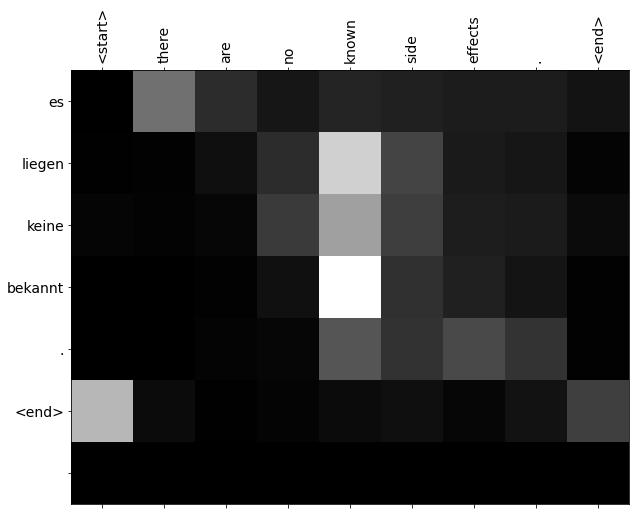

In [49]:
translate('There are no known side-effects.')

In [40]:
!tensorboard dev upload --logdir "/content/out/tensorboard/logs/" \
  --name "{config.logging.name}" \
  --description "{config.logging.description}" \
  --one_shot

2021-05-20 21:33:34.042758: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/LmYkpbnRQ3imVlHOljdhmA/

[2021-05-20T21:33:35] Started scanning logdir.
[2021-05-20T21:33:40] Total uploaded: 17333 scalars, 0 tensors, 0 binary objects
[2021-05-20T21:33:40] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/LmYkpbnRQ3imVlHOljdhmA/


In [38]:
config.logging.dir

'/content/out/tensorboard/logs/'

In [45]:
data_src_1 = '/content/out/training_checkpoints/ckpt-5.data-00000-of-00001'
data_dest_1 = '/content/drive/MyDrive/Colab Notebooks/Data/seq2seqcheckpoints/ckpt-5.data-00000-of-00001'

data_src_2 = '/content/out/training_checkpoints/ckpt-5.index'
data_dest_2 = '/content/drive/MyDrive/Colab Notebooks/Data/seq2seqcheckpoints/ckpt-5.index'

In [46]:
d = shutil.copyfile(data_src_2, data_dest_2)